# Modeling of a Torsional Spring in Optickle

This notebooks adds the pendulum dynamics of the mirrors to a simple Fabry Perot cavity, computes the optical response to angular motion, and computes the effects of radiation pressure on the mirror dynamics.

[__1.__](#model) Model definition

[__2.__](#frequency-response) Compute frequency response

[__3.__](#optical-response) Optical response

[__4.__](#mechanical-response) Radiation pressure modification of the mechanical response

The FinesseTorsionalSpring notebook goes through the identical calculations with Finesse.

In [1]:
# The matlab engine must first be started.
# This takes a few seconds but only needs to be done once
import matlab.engine
eng = matlab.engine.start_matlab()

In [2]:
import numpy as np
import pytickle.optickle as pyt
import pytickle.controls as ctrl
from pytickle.plotting import plotTF
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mpl.rc('figure', figsize=(8, 11))

mpl.rcParams.update({'text.usetex': False,
                     'mathtext.fontset': 'cm',
                     'lines.linewidth': 3,
                     'lines.markersize': 10,
                     'font.size': 16,
                     'axes.grid': True,
                     'grid.alpha': 0.5,
                     'legend.loc': 'best',
                     'savefig.dpi': 80,
                     'pdf.compression': 9})

In [4]:
# This adds the path to Optickle to Matlab's path and assumes the OPTICKLE_PATH variable has been defined.
# If it has not, use
# pyt.addOpticklePath(eng, path_to_optickle)
# instead.
pyt.addOpticklePath(eng)

<a name="model"> </a>

## Model Definition

See BasicOptickleFP for an introduction to Optickle model building.

In [5]:
fmod = 11e3  # modulation frequency [Hz]
gmod = 0.1   # modulation depth
Pin = 10e3   # input power [W]
Ti = 0.014   # ITM transmissivity
Lcav = 40e3  # cavity length [m]
Ri = 34e3    # ITM radius of curvature [m]
Re = 36e3    # ETM radius of curvature [m]

# Mechanical response of the torsional pendulum
I = 25   # moment of inertia of the mirror [kg m^2]
f0 = 1   # resonance frequency [Hz]
Q = 100  # Q factor
poles = np.array(ctrl.resRoots(2*np.pi*f0, Q, Hz=False))

vRF = np.array([-fmod, 0, fmod])

opt = pyt.PyTickle(eng, 'opt', vRF)

# make the cavity
opt.addMirror('EX', Chr=1/Re)
opt.addMirror('IX', Thr=Ti, Chr=1/Ri)
opt.addLink('IX', 'fr', 'EX', 'fr', Lcav)
opt.addLink('EX', 'fr', 'IX', 'fr', Lcav)
opt.setCavityBasis('IX', 'EX')

# set the pitch response by giving a zpk definition of the dynamics
opt.setMechTF('EX', [], poles, 1/I, dof='pitch')
opt.setMechTF('IX', [], poles, 1/I, dof='pitch')

# add input
opt.addSource('Laser', np.sqrt(Pin)*(vRF == 0))
opt.addRFmodulator('Mod', fmod, 1j*gmod)  # RF modulator for PDH sensing
opt.addLink('Laser', 'out', 'Mod', 'in', 0)
opt.addLink('Mod', 'out', 'IX', 'bk', 0)

# add DC and RF photodiodes
opt.addSink('REFL')
opt.addLink('IX', 'bk', 'REFL', 'in', 0)
opt.addReadout('REFL', fmod, 0)

The free mechanical response of the pendulum must be defined to compute the effects of radiation pressure. The command
```python
opt.setMechTF(name, zs, ps, z, dof)
```
sets this response for the optic called `name` to a mechanical plant specified by zeros, poles, and a gain. The convenience function `resRoots(omega0, Q)` computes the conjugate poles (or zeros) of a resonance with a given frequency and Q factor.

When working with higher order modes, a Hermite-Gauss basis must be defined. The simplest way to do this is to have Optickle compute it by using the basis of a stable cavity. The command `setCavityBasis(mirr1, mirr2)` tells Optickle to use the cavity formed by `mirr1` and `mirr2` to define the basis. Multiple cavities can be used to define the basis in more complicated models.

<a name="frequency-response"> </a>

## Frequency Response

See BasicOptickleFP for an overview of frequency response calculations. Since we are interested in the pitch dynamics here we have to run the model with the `dof` (degree of freedom) keyword:
```python
opt.run(ff, dof='pitch')
```

In [6]:
# compute the AC response matrix, i.e. the optomechanical plant
fmin = 1e-1
fmax = 30
npts = 1000
ff = np.logspace(np.log10(fmin), np.log10(fmax), npts)
opt.run(ff, dof='pitch', noise=False)

Transfer functions which are linear combinations of drives can also be computed directly by specifying those combinations as a dictionary. In this case we'll look at the hard $\theta_\mathrm{h}$ and soft $\theta_\mathrm{s}$ modes defined as
$$\begin{bmatrix}
\theta_\mathrm{s}\\
\theta_\mathrm{h}
\end{bmatrix}
=
\begin{bmatrix}
r & 1 \\
-1 & r
\end{bmatrix}
\begin{bmatrix}
\theta_\mathrm{i}\\
\theta_\mathrm{e}
\end{bmatrix}, \qquad
r = \frac{2}{(g_\mathrm{i} - g_\mathrm{e}) + \sqrt{(g_\mathrm{i} - g_\mathrm{e})^2 + 4}}, \qquad
g_{\mathrm{e}(\mathrm{i})} = 1 - \frac{L}{R_{\mathrm{e}(\mathrm{i})}}
$$

In [7]:
gi = 1 - Lcav/Ri
ge = 1 - Lcav/Re
r = 2/((gi - ge) + np.sqrt((gi - ge)**2 + 4))

HARD = dict(IX=-1, EX=r)
SOFT = dict(IX=r, EX=1)

<a name="optical-response"> </a>

### Optical response

See BasicOptickleFP for an overview of calculating transfer functions.

In [8]:
# transfer functions can be computed directly
tf_REFL_I_SOFT = opt.getTF('REFL_I', SOFT, dof='pitch')

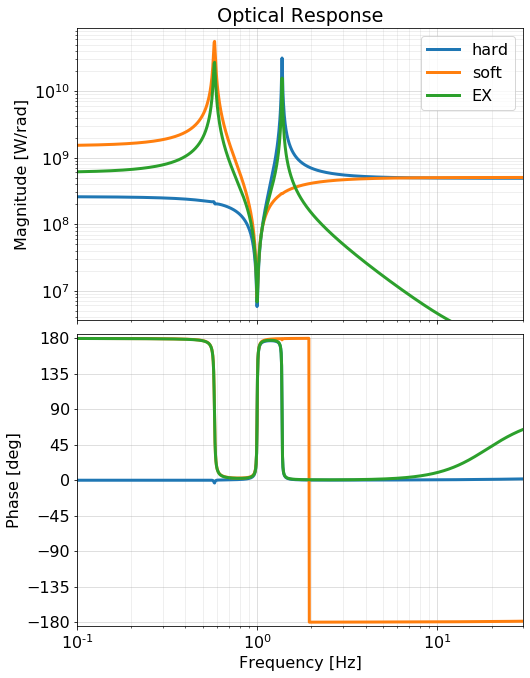

In [9]:
# plotTF is a convenience function to quickly plot a transfer function
fig = opt.plotTF('REFL_I', HARD, dof='pitch', label='hard');
plotTF(ff, tf_REFL_I_SOFT, fig.axes[0], fig.axes[1], label='soft');
opt.plotTF('REFL_I', 'EX', fig.axes[0], fig.axes[1], dof='pitch', label='EX')
fig.axes[0].legend();
fig.axes[0].set_title('Optical Response');
fig.axes[0].set_ylabel('Magnitude [W/rad]');

<a name="mechanical-response"> </a>


### Radiation pressure modification of the mechanical response

The radiation pressure stiffens the hard mode increasing the resonance frequency from that of the free pendulum and softens the soft mode decreasing the resonance frequency.

```python
opt.getMechTF(drive_to, drive_from, dof)
```
calculates the mechanical response of `drive_to` due to forces or torques on `drive_from`. As with `getTF`, the drives can be either strings for a single drive or a dictionaries specifying linear combinations of drives.

In [10]:
# For comparisson, define a filter showing the free pendulum response
# More on filters in the control systems example. This is just for plotting here
pend = ctrl.Filter([], poles, 1/I, Hz=False)

In [11]:
# Again, mechanical transfer functions can be computed directly
tf_mech_SOFT = opt.getMechTF(SOFT, SOFT, dof='pitch')

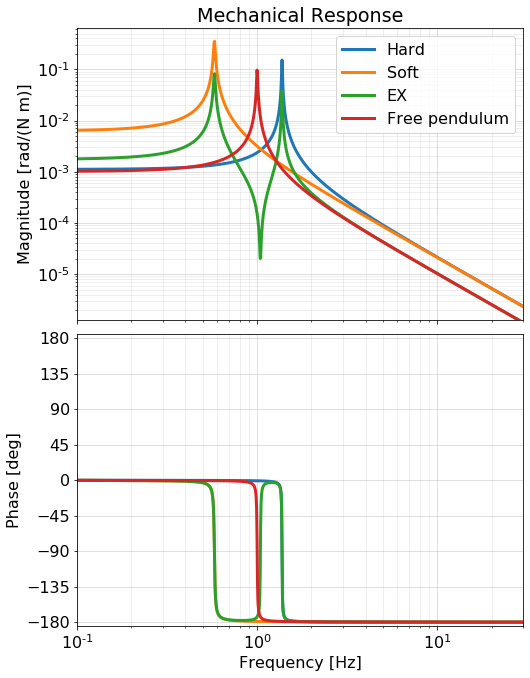

In [12]:
# and plotMechTF is a convenience function
fig = opt.plotMechTF(HARD, HARD, dof='pitch', label='Hard')
plotTF(ff, tf_mech_SOFT, fig.axes[0], fig.axes[1], label='Soft')
opt.plotMechTF('EX', 'EX', fig.axes[0], fig.axes[1], dof='pitch', label='EX')
pend.plotFilter(ff, fig.axes[0], fig.axes[1], label='Free pendulum')
fig.axes[0].legend();
fig.axes[0].set_title('Mechanical Response');
fig.axes[0].set_ylabel('Magnitude [rad/(N m)]');

In [22]:
opt.getFieldBasis('IX', 'bk', verbose=True)

Taking the basis determined by the model


(-15274.980635166534+11173.492127192538j)

In [20]:
opt.getFieldBasis('IX')

(16000+16970.56274847714j)